# Week 2: Introduction to Neural Networks


In this section, we will introduce neural networks.

## Overview

* General-purpose curve fitting requirements
 *  A function which is robust enough to fit any data we throw at it
 *  A training algorithm for this function which conforms to physical constraints of a computer
* Why are neural networks a good solution?
* Neural networks as mathematical function
* Deep vs. Shallow networks
* First look at Tensorflow and Keras

**Key Vocab:**

* Neural Network
* Universal Approximation Theorem
* Feed-Forward Neural Network
* Deep Learning
* Weights/Bias
* Activation Function
* Layer
* Keras
 * Sequential Model
 * Dense Layers
 * Model Compilation

In [8]:
# Libraries we will use in this lesson

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as K

2024-12-02 13:49:16.413960: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 13:49:16.414900: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 13:49:16.417685: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 13:49:16.424800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733165356.437954   35757 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733165356.44

## General Purpose Curve Fitting

We want a mathematical function which satisfies the following requirements:

1. The function is robust enough to allow it to fit any general data by setting the function's parameters
2. There is a companion training algorithm which we can use to _find_ good parameters

It turns out that these two requirements can be satisfied with a _neural network_.

## Our First Neural Network as a Mathematical Function

Over the next few sections, we will build up a neural network mathematically, and then implement it in Python.

Let's begin by giving the formal definition of a basic neural network:

---

**Neural Network**

Let $F$ be a function

$$F\left(\vec{x}; W_0, W_1, \vec{b}_0, \vec{b}_1\right) = \hat{y}$$

where $\vec{x}$ is an input vector, $W_0$ and $W_1$ are parameter matrices, 
$\vec{b}_0$, and $\vec{b}_1$ are parameter vectors, and $\hat{y}$ is the output vector.
The function $F$ has the form

$$F(\vec{x}) = \phi_1\left(W_1 \phi_0\left(W_0\vec{x} + \vec{b}_0\right) + \vec{b}_1\right)$$

where $\phi_0$ is a nonlinear function, and $\phi_1$ is a (not necessarily nonlinear) function.

Then $F$ is said to be a *single layer neural network*.
The functions $\phi_0$ and $\phi_1$ are called _activation functions_.
The matrices $W_0$ and $W_1$ are called _weight matrices_.
The vectors $\vec{b}_0$ and $\vec{b}_1$ are called _bias vectors._

---

We will now implement this function in Python, using `numpy` to handle our matrix multiplication.

For now, we will omit the outside activation function $\phi_1$.
For the inside activation function $\phi_0$, we will use a simple signum function:

$$\phi_0(x) = \left\{\begin{array}{ccc}
0 & \text{if} & x \leq 0 \\
1 & \text{if} & x > 0
\end{array}\right.
$$

Remember, that _any_ non-linear function will work here, this one is just very easy to work with for the time being.

In [2]:
def step(x):
    """An activation function which returns 0 for negative values and 1 for positive values."""
    
    return np.where(x <= 0, 0, 1)

Text(0.5, 1.0, 'Step Activation Function')

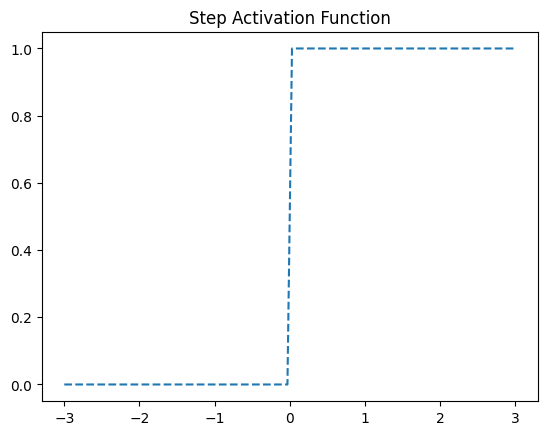

In [3]:
xs = np.linspace(-3, 3, 100)
ys = step(xs)

plt.plot(xs, ys, '--')
plt.title("Step Activation Function")

Next, we will implement the neural network class.
For now, we will pass in the weight and bais matrices as parameters.

In [4]:
class MyNeuralNetwork:
    """A simple neural network class."""
    
    def __init__(self, w0, w1, b0, b1):
        # Store the parameter matrices as class attributes
        self.w0 = w0
        self.w1 = w1
        self.b0 = b0
        self.b1 = b1
    
    def __call__(self, x):
        """Call the NN function."""
        
        # Note: We multiply the matrix on the right in the code
        #       to satisfy numpy's requirements.
        
        return step(x @ self.w0 + self.b0) @ self.w1 + self.b1

We will now test this neural class network out!
Let's create a simple function of one variable, which has one output:

Text(0.5, 1.0, 'Simple Neural Network')

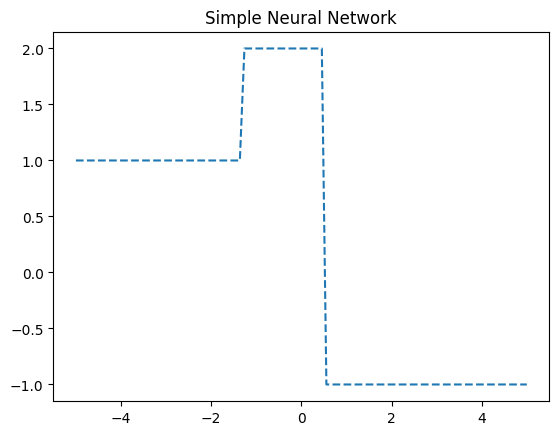

In [5]:
# Testing out the Neural Network Class

nn = MyNeuralNetwork(
    w0 = np.array([[1, 3, -2]]),     # 1 x 3 matrix
    w1 = np.array([[0], [1], [3]]),  # 3 x 1 matrix
    b0 = np.array([-1, 4, 1]),       # 3-vector
    b1 = np.array([-2]),             # 1-vector
)


# Make a plot of the output
xs = np.linspace(-5, 5, 100).reshape(-1, 1)
ys = nn(xs)

plt.plot(xs, ys, '--')
plt.title("Simple Neural Network")

### A Notation Simplification

Let's make a simplification to our neural network's implementation.
Notice that we always multiply by a weight matrix and then add a bias vector.

$$W\vec{x} + \vec{b}$$

We can simplify this by creating the convention that our feature vector $\vec{x}$ will always have a 1 in the first position:

$$\left[x_1 \, x_2 \, ... \, x_n \right] \rightarrow \left[1 \, x_1 \, x_2 \, ... \, x_n \right]$$

We can then append the bias vector $\vec{b}$ to the weight matrix $W$:

$$\left[\begin{array}{ccc}
\vdots & & \vdots \\
\vec{w}_1 &\cdots & \vec{w}_n \\
\vdots & & \vdots
\end{array}\right] \rightarrow \left[\begin{array}{cccc}
\vdots & \vdots & & \vdots \\
\vec{b} & \vec{w}_1 &\cdots & \vec{w}_n \\
\vdots & \vdots & & \vdots
\end{array}\right]$$

With the $\vec{b}$ vector incorporated into the $W$ matrix, we can now rewrite our neural network formula:

$$F(\vec{x}) = \phi_1\left(W_1 \phi_0\left(W_0\vec{x}\right)\right)$$

We can now refer to the 1 in the $\vec{x}$ vector as $x_0$ and the bias vector as $\vec{w}_0$.

---

Next, let's incorporate this simplification into our Python class:

In [6]:
class MyNeuralNetworkV2:
    """A simple neural network class."""
    
    def __init__(self, w0, w1):
        self.w0 = w0
        self.w1 = w1
    
    def __call__(self, x):
        """Call the NN function."""
        
        # Append 1 to the first position of the x vector
        ones_vector = np.ones_like(x[:, :1])
        x = np.hstack([ones_vector, x])
        
        # Apply activation function
        z = step(x @ self.w0)

        # Append 1 vector to first position
        ones_vector = np.ones_like(z[:, :1])
        z = np.hstack([ones_vector, z])
        
        # Return result
        return z @ self.w1

Text(0.5, 1.0, 'Simple Neural Network - Simplified version')

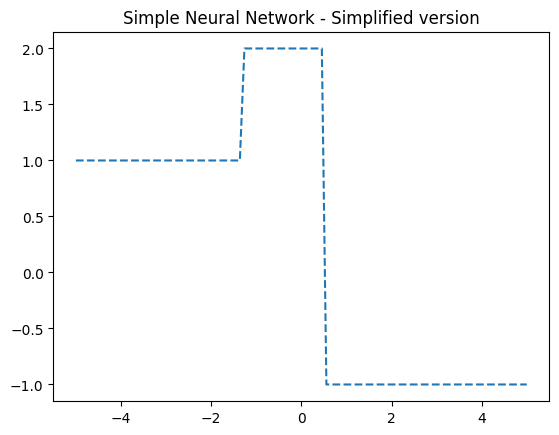

In [7]:
# Testing out the Neural Network Class
# This should look the same as before

nn = MyNeuralNetworkV2(
    w0 = np.array([[-1, 4, 1], [1, 3, -2]]),     # 2 x 3 matrix
    w1 = np.array([[-2], [0], [1], [3]]),  # 4 x 1 matrix
)


# Make a plot of the output
xs = np.linspace(-5, 5, 100).reshape(-1, 1)
ys = nn(xs)

plt.plot(xs, ys, '--')
plt.title("Simple Neural Network - Simplified version")

## Neural Networks as a Sequence of Layers

While the formulation of neural networks we have developed above is useful for simple situations,
it can often be useful to think about them in a slightly different way once things get more complicated.

---

<center>
<img src="../images/Colored_neural_network.svg" />

**image source: Wikipedia**
</center>

---

Here we have a typical illustration of a neural network with individual neurons as circles, and the weights as arrows. This network has one input layer, one hidden layer, and one output layer.

This conceptualization of neural networks as being built out of layers does not change the underlying math, it is only a way to help us reason about the network.
In our mathematical function, the input layer corresponds to the vector $\vec{x}$, the hidden layer corresponds to the first matrix multiplication and activation $\phi_0(W_0\vec{x})$, and the output layer corresponds to the value of the entire function $F$.


## Tensorflow and Keras

We will now abandon our intial neural network code we wrote ourselves in favor of a newtwork which uses Keras.

### What is Tensorflow?

Tensorflow is a low-level library, implemented in C, and wrapped with a Python API which allows us to create neural networks out of mathematical functions.
The main benefits of Tensorflow is that it allows us to efficiently run our networks on a CPU or GPU, and the ability to automatically compute derivitives.
We will learn more about why this is important in a future lesson when we talk about training.
The reason we say this is is low level is because Tensorflow code tends to resemble the mathematical functional view of a neural network.

Tensorflow is created and maintained by Google.
There is a competing library called _PyTorch_ which was created by Facebook.
Nowadays, Tensorflow tends to be more popular in industry, while PyTorch tends to be more popular in industry
(although this is not universally true).


### What is Keras?

Keras is a high-level library built on top of Tensorflow which allows you to build neural networks using the more approachable concepts of layers.
While originally a separate library, Keras was officially incorporated into Tensorflow in version 2.0 and now comes standard with all Tensorflow installations.

Check out the Keras documentation [here](https://keras.io/api/) to learn more.

### Creating a Neural Network Using Keras

To create a neural network with Keras, we will use the `Sequential` API.
There is also a `Model` API which we can use for more complicated models, but we will stick with sequential for now.

In [36]:
# Creating a neural network with Keras

def step_tf(x):
    """Step function implemented using Tensorflow."""
    return tf.maximum (tf.sign( x ), 0.0 )


model = K.Sequential()

model.add(K.layers.Input((1, ), name='input_layer'))
model.add(K.layers.Dense(3, activation=step_tf, name='hidden_layer'))
model.add(K.layers.Dense(1, activation='linear', name='output_layer'))  # Note: 'linear' is the default so isn't strictly needed here

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer (Dense)            │ (None, 3)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

Text(0.5, 1.0, 'Simple Neural Network - Simplified version')

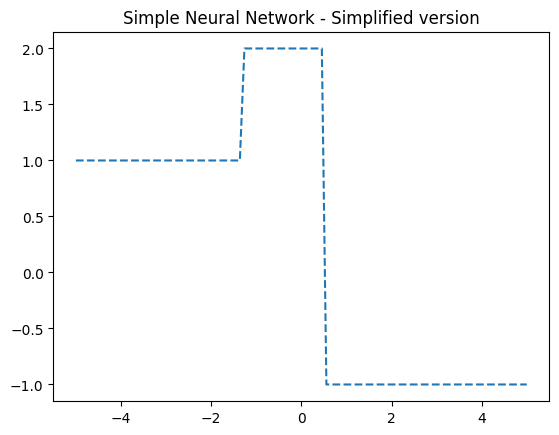

In [37]:
# Assign the model weights we were using before to this model
# Normally we would find these weights by training, so this is not normally done.

model.set_weights([
    np.array([[1, 3, -2]]),
    np.array([-1, 4, 1]),
    np.array([[0], [1], [3]]),
    np.array([-2]),
])

# Make a plot of the output
xs = np.linspace(-5, 5, 100).reshape(-1, 1)
ys = model(xs)

plt.plot(xs, ys, '--')
plt.title("Simple Neural Network - Simplified version")

## Using Neural Networks for Classification Problems

Up until now, we have been looking at neural networks which predict a continuous value.
This is typical for regression problems, when we want to predict the amount of something.

**FINISH THIS SECTION**

### The Softmax Function

When performing classification, 

$$softmax\left(\vec{x}\right) = \frac{1}{\sum_{j=0}^N e^{x_j}} \cdot \left[\begin{array}{c}
e^{x_0} \\
\vdots \\
e^{x_N}
\end{array} \right]$$

This function has two nice properties:

1. Each entry in its output is positive, no matter the input values.
2. The sum of all entries will always equal 1.0.

This means that we can interpret the values of this vector as _probabilities_.
This is great for classification problems!
We can set up our neural network to have an output layer which has a number of entries which is equal to the number of classes.
We then interpret the output vector $\vec{y}$'s $i^{th}$ entry as the probablity that the given input is of class $i$.

We can then take the largest probability as the final prediction of the neural network.

**PUT A PICTURE HERE OF APPLE, LEMON, ORANGE HERE**

In [3]:
np.sum([1, 2, 3])

6

In [6]:
# Softmax in Python code

def softmax(x):
    numerator = np.exp(x)
    
    denominator = np.sum(numerator)
    
    return numerator / denominator


## Example

vec = np.array([[1, -2, 3]])

softmax(vec)

array([[0.11849965, 0.00589975, 0.8756006 ]])

# Homework Questions

1. Define the concepts of layers and activation functions.
2. Using the `MyNeuralNetwork` class from this lesson, experiment with different weight matrices.
Create three different neural networks with various values and sizes. Plot the output of out neural network function and explain what you can see changes as you change the weight matrix.
3. Create a `MyNeuralNetworkV3` class which uses the sigmoid activation function instead of the step function. Plot this network's output and describe in your own words how this differs from the step-function version.
4. Why is it important to include a non-linear activation function in our neural network?
5. Explain what we mean by a deep neural network vs. a shallow network.
6. What is the softmax function? When would you use it?